In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out Python Warnings
import warnings
warnings.filterwarnings('ignore')

# Configure CUBLAS workspace to 16:8 for more determinism (Reproducibility)
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

csv_path = '/kaggle/input/apple-quality/apple_quality.csv'

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/apple-quality/apple_quality.csv


# 1. Preprocessing

## 1.1 Quick look at the dataset to see outliers and missing values

In [3]:
df = pd.read_csv(csv_path)
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [4]:
# Will need to remove last row - authors note 
df.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [5]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


### ***Remove last row, since author's note is not part of the dataset***

In [6]:
df.drop(df.tail(1).index,inplace=True)

In [7]:
df.tail()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3995,3995.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784369,bad
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


### ***Remove the first column, since id column has no meaning and large values of unique values***

In [8]:
df.drop('A_id', axis=1, inplace=True)

In [9]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


### **Column: Acidity is an object type, but it should be a float.**
We will convert the object column from object data type to a float data type.

In [10]:
df['Acidity'] = df['Acidity'].astype(float)

In [11]:
df['Acidity'].dtype

dtype('float64')

In [12]:
df['Acidity']

0      -0.491590
1      -0.722809
2       2.621636
3       0.790723
4       0.501984
          ...   
3995    0.137784
3996    1.854235
3997   -1.334611
3998   -2.229720
3999    1.599796
Name: Acidity, Length: 4000, dtype: float64

## Check for Missing Values

In [13]:
# No missing values found
df.isnull().sum()

Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

## Check for Duplications

In [14]:
# No duplicates were found
df.duplicated().sum()

0

In [15]:
target = df['Quality']
df = df.drop('Quality', axis=1)

In [16]:
df.merge(target, how='outer', left_index=True, right_index=True)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good
...,...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,bad
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,good
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,bad
3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,good


## Split the dataset into train and test sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3200, 7) (800, 7) (3200,) (800,)


# 2. Exploratory Data Analysis

### 2.1 Check for class imbalance in target variable

In [18]:
# The Target variable is evenly distributed, theres no need to stratify or balance the dataset
target

0       good
1       good
2        bad
3       good
4       good
        ... 
3995     bad
3996    good
3997     bad
3998    good
3999    good
Name: Quality, Length: 4000, dtype: object

<Axes: xlabel='Quality', ylabel='Count'>

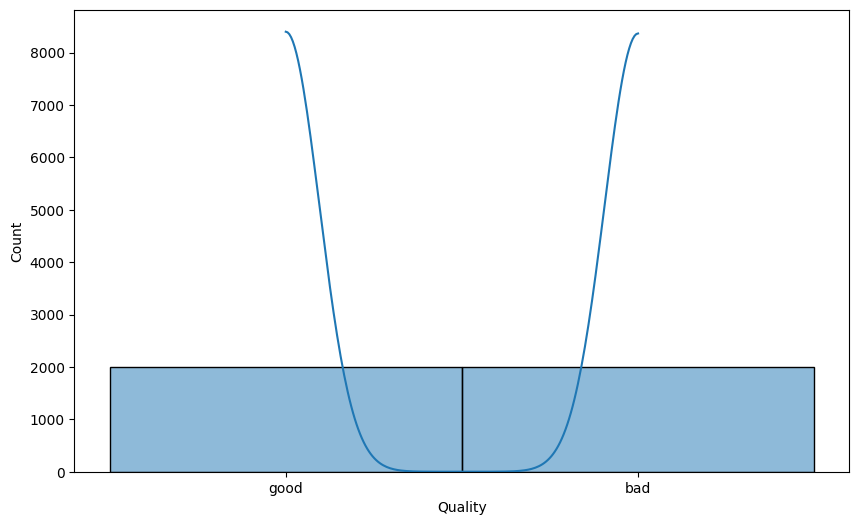

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(target, kde=True)

In [ ]:
# There are no distinct trends in the data, mostly due to the already standardized data
sns.pairplot(df)

Each histogram for each individual feature is plotted to see the distribution of the data. We can see that the data is normally distributed for all of the features, so there is no need to normalize the data.

## Plot Heatmap to check for correlation between features

<Axes: >

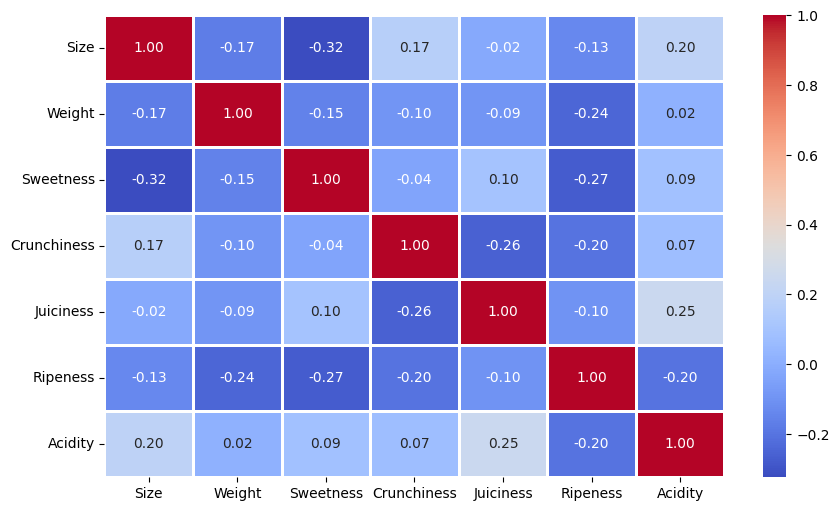

In [21]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', linewidths=2)

There are no features that relatively stand out as highly correlated. We can see that the highest correlation is between the features "Sweetness" and "Size" with a correlation of -0.32. We'll use xgboost to check for feature importance.

# 3. Pipeline and Model Building

### 3.1 Base Model: XGBoost (non-tuned)

In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [23]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Create an instance of StratifiedKFold for categorical target variable
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')

# Train the model
scores = cross_val_score(xgb_clf, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)

print(f'Cross Validation Scores: {scores}')
print(f'Mean Cross Validation Score: {scores.mean()}')

Cross Validation Scores: [0.95664997 0.94765574 0.95953085 0.96137658 0.94103458]
Mean Cross Validation Score: 0.9532495434525726


In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

xgb_clf.fit(X_train, y_train_encoded)

y_pred = xgb_clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

confusion_matrix(y_test_encoded, y_pred)

Accuracy: 0.90625
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       401
           1       0.91      0.91      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

AUC Score: 0.9062525390783692


array([[363,  38],
       [ 37, 362]])

### 3.2 Tuning the model using Optuna

In [25]:
import optuna

In [26]:
def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **xgb_params)
    
    scores = cross_val_score(xgb_clf, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)
    
    return scores.mean()

In [27]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

[I 2024-04-03 19:35:35,116] A new study created in memory with name: no-name-dbdd2bc1-f348-46b7-b2f4-5d578a145e70


In [28]:
study.optimize(objective, n_trials=50)

[I 2024-04-03 19:35:36,139] Trial 0 finished with value: 0.9494565376615005 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.15599452033620265, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352, 'min_child_weight': 7}. Best is trial 0 with value: 0.9494565376615005.
[I 2024-04-03 19:35:36,917] Trial 1 finished with value: 0.9471889373919667 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'gamma': 0.18182496720710062, 'reg_alpha': 1.8340450985343382, 'reg_lambda': 3.0424224295953772, 'min_child_weight': 6}. Best is trial 0 with value: 0.9494565376615005.
[I 2024-04-03 19:35:37,726] Trial 2 finished with value: 0.9443490659088468 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'subsample': 0

In [29]:
best_params = study.best_params

### Trying out tuned XGBoost model

In [30]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **best_params)

xgb_clf.fit(X_train, y_train_encoded)

y_pred = xgb_clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

confusion_matrix(y_test_encoded, y_pred)

Accuracy: 0.90625
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       401
           1       0.91      0.91      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

AUC Score: 0.9062525390783692


array([[363,  38],
       [ 37, 362]])

In [31]:
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study)

<Figure size 1000x600 with 0 Axes>

### 3.3 Catboost Base Model

In [39]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.3


In [65]:
# Create a CatBoostClassifier model
cat_clf = CatBoostClassifier(task_type='GPU', iterations=100, verbose=0)

scores = cross_val_score(cat_clf, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc')

print(f'Cross Validation Scores: {scores}')

print(f'Mean Cross Validation Score: {scores.mean()}')

Cross Validation Scores: [0.95027295 0.94547798 0.9655563  0.96677702 0.94680612]
Mean Cross Validation Score: 0.9549780759577731


In [63]:
# Fit the model to the training data
cat_clf.fit(X_train, y_train_encoded)

# Predict on the test data
y_pred = cat_clf.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

confusion_matrix(y_test_encoded, y_pred)

Accuracy: 0.9075
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       401
           1       0.90      0.92      0.91       399

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800

AUC Score: 0.9075244220276378


array([[360,  41],
       [ 33, 366]])

### 3.4 Voting Classifier

In [45]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the individual classifiers
classifier1 = DecisionTreeClassifier(random_state=42)
classifier2 = LogisticRegression(random_state=42)
classifier3 = SVC(random_state=42, probability=True)
classifier4 = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', **best_params)
classifier5 = RandomForestClassifier(random_state=42)
classifier6 = CatBoostClassifier(task_type='GPU', iterations=100, verbose=0)

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('dt', classifier1), ('lr', classifier2), ('svc', classifier3), ('xgb', classifier4), ('cat', classifier5)],
    voting='soft'  # soft voting
)

scores = cross_val_score(voting_classifier, X_train, y_train_encoded, cv=stratified_kfold, n_jobs=-1)

print(f'Cross Validation Scores: {scores}')

print(f'Mean Cross Validation Score: {scores.mean()}')


Cross Validation Scores: [0.875     0.865625  0.884375  0.8765625 0.8625   ]
Mean Cross Validation Score: 0.8728125


In [75]:
# Create a new Objective function for Optuna for the Voting Classifier
def objective(trial):
    dt_params = {
        'criterion': trial.suggest_categorical('dt_criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('dt_max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('dt_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('dt_min_samples_leaf', 1, 10)
    }
    
    lr_params = {
        'C': trial.suggest_loguniform('lr_C', 0.1, 10.0),
        'max_iter': trial.suggest_int('lr_max_iter', 100, 1000),
        'l1_ratio': trial.suggest_float('lr_l1_ratio', 0, 1)
    }
    
    svc_params = {
        'C': trial.suggest_loguniform('svc_C', 0.1, 10.0),
        'gamma': trial.suggest_loguniform('svc_gamma', 0.01, 1.0),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10)
    }
    
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 0.0, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 0.0, 10.0),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10)
    }

    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 300),
        'learning_rate': trial.suggest_loguniform('cat_learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('cat_depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 0.0, 10.0)
    }
    
    # 1. Decision Tree
    dt_clf = DecisionTreeClassifier(max_depth=dt_params['max_depth'], min_samples_split=dt_params['min_samples_split'], 
                                    min_samples_leaf=dt_params['min_samples_leaf'], criterion=dt_params['criterion'],random_state=42)

    # 2. Logistic Regression
    lr_clf = LogisticRegression(max_iter=lr_params['max_iter'], C=lr_params['C'], solver='saga', 
                                penalty='elasticnet', l1_ratio=lr_params['l1_ratio'], random_state=42)

    # 3. Support Vector Classifier
    svc_clf = SVC(probability=True, C=svc_params['C'], gamma=svc_params['gamma'], kernel=svc_params['kernel'], random_state=42)

    # 4. XGBoost Classifier
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', n_estimators=xgb_params['n_estimators'], 
                            max_depth=xgb_params['max_depth'], learning_rate=xgb_params['learning_rate'], subsample=xgb_params['subsample'], 
                            colsample_bytree=xgb_params['colsample_bytree'], reg_alpha=xgb_params['reg_alpha'], 
                            reg_lambda=xgb_params['reg_lambda'], min_child_weight=xgb_params['min_child_weight'], random_state=42)

    # 5. Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=rf_params['n_estimators'], max_depth=rf_params['max_depth'], 
                                    min_samples_split=rf_params['min_samples_split'], min_samples_leaf=rf_params['min_samples_leaf'], 
                                    random_state=42)
    # 6. CatBoost Classifier
    cat_clf = CatBoostClassifier(eval_metric='AUC', iterations=cat_params['iterations'], learning_rate=cat_params['learning_rate'],
                                depth=cat_params['depth'], l2_leaf_reg=cat_params['l2_leaf_reg'], verbose=False,random_state=42)

    # Suggest weights for each model
    models = [dt_clf, lr_clf, svc_clf, rf_clf, xgb_clf, cat_clf]

    weights = [trial.suggest_float(f'weight_{i}', 0, 1) for i in range(len(models))]
    
    # Ensure weights sum to 1 (optional)
    total = sum(weights)
    weights = [w / total for w in weights]
               
    voting_classifier = VotingClassifier(
        estimators=[('dt', dt_clf), ('lr', lr_clf), ('svc', svc_clf), ('rf', rf_clf), ('xgb', xgb_clf), ('cat', cat_clf)],
        voting='soft', # soft voting
        weights=weights
    )

    scores = cross_val_score(voting_classifier, X_train, y_train_encoded, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1)

    return scores.mean()

In [76]:
study1 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))

[I 2024-04-03 20:07:10,156] A new study created in memory with name: no-name-d1832297-d8ac-4fc4-b313-1ad2cbb042ec


In [77]:
study1.optimize(objective, n_trials=50)

[I 2024-04-03 20:08:08,361] Trial 0 finished with value: 0.9556011289172746 and parameters: {'dt_criterion': 'entropy', 'dt_max_depth': 8, 'dt_min_samples_split': 7, 'dt_min_samples_leaf': 2, 'lr_C': 0.2051110418843398, 'lr_max_iter': 152, 'lr_l1_ratio': 0.8661761457749352, 'svc_C': 1.5930522616241019, 'svc_gamma': 0.2607024758370766, 'svc_kernel': 'poly', 'rf_n_estimators': 263, 'rf_max_depth': 4, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 6, 'xgb_n_estimators': 489, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.08012737503998542, 'xgb_subsample': 0.569746930326021, 'xgb_gamma': 0.29214464853521815, 'xgb_colsample_bytree': 0.6831809216468459, 'xgb_reg_alpha': 4.56069984217036, 'xgb_reg_lambda': 7.851759613930136, 'xgb_min_child_weight': 2, 'cat_iterations': 203, 'cat_learning_rate': 0.10150667045928574, 'cat_depth': 3, 'cat_l2_leaf_reg': 6.075448519014383, 'weight_0': 0.17052412368729153, 'weight_1': 0.06505159298527952, 'weight_2': 0.9488855372533332, 'weight_3': 0.96563203307455

In [78]:
study1.best_params
# {'dt_criterion': 'entropy',
#  'dt_max_depth': 4,
#  'dt_min_samples_split': 8,
#  'dt_min_samples_leaf': 8,
#  'lr_C': 6.527549752972141,
#  'lr_max_iter': 969,
#  'lr_l1_ratio': 0.4337568671456013,
#  'svc_C': 1.5556857873966423,
#  'svc_gamma': 0.14681019428301498,
#  'svc_kernel': 'rbf',
#  'rf_n_estimators': 854,
#  'rf_max_depth': 6,
#  'rf_min_samples_split': 2,
#  'rf_min_samples_leaf': 9,
#  'xgb_n_estimators': 452,
#  'xgb_max_depth': 10,
#  'xgb_learning_rate': 0.013838262695355694,
#  'xgb_subsample': 0.9823543338269651,
#  'xgb_gamma': 0.4258753464801609,
#  'xgb_colsample_bytree': 0.9949459559325061,
#  'xgb_reg_alpha': 2.996709566294335,
#  'xgb_reg_lambda': 6.103699549880966,
#  'xgb_min_child_weight': 1,
#  'cat_iterations': 290,
#  'cat_learning_rate': 0.026194095599180893,
#  'cat_depth': 7,
#  'cat_l2_leaf_reg': 1.8230381229344372,
#  'weight_0': 0.17038800826859224,
#  'weight_1': 0.002015723587246221,
#  'weight_2': 0.7966047820136877,
#  'weight_3': 0.27321856019502155,
#  'weight_4': 0.2480176764173019,
#  'weight_5': 0.7660175887545655}

{'dt_criterion': 'entropy',
 'dt_max_depth': 4,
 'dt_min_samples_split': 8,
 'dt_min_samples_leaf': 8,
 'lr_C': 6.527549752972141,
 'lr_max_iter': 969,
 'lr_l1_ratio': 0.4337568671456013,
 'svc_C': 1.5556857873966423,
 'svc_gamma': 0.14681019428301498,
 'svc_kernel': 'rbf',
 'rf_n_estimators': 854,
 'rf_max_depth': 6,
 'rf_min_samples_split': 2,
 'rf_min_samples_leaf': 9,
 'xgb_n_estimators': 452,
 'xgb_max_depth': 10,
 'xgb_learning_rate': 0.013838262695355694,
 'xgb_subsample': 0.9823543338269651,
 'xgb_gamma': 0.4258753464801609,
 'xgb_colsample_bytree': 0.9949459559325061,
 'xgb_reg_alpha': 2.996709566294335,
 'xgb_reg_lambda': 6.103699549880966,
 'xgb_min_child_weight': 1,
 'cat_iterations': 290,
 'cat_learning_rate': 0.026194095599180893,
 'cat_depth': 7,
 'cat_l2_leaf_reg': 1.8230381229344372,
 'weight_0': 0.17038800826859224,
 'weight_1': 0.002015723587246221,
 'weight_2': 0.7966047820136877,
 'weight_3': 0.27321856019502155,
 'weight_4': 0.2480176764173019,
 'weight_5': 0.7660

In [79]:
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study1)

<Figure size 1000x600 with 0 Axes>

### 3.5 Voting Classifier Model Evaluation

In [80]:
# Best parameters for voting classifier
best_params = study1.best_params

# Create the Voting Classifier
voting_classifier = VotingClassifier(
    estimators=[('dt', DecisionTreeClassifier(criterion=best_params['dt_criterion'], max_depth=best_params['dt_max_depth'],
                                              min_samples_split=best_params['dt_min_samples_split'],
                                              min_samples_leaf=best_params['dt_min_samples_leaf'], random_state=42)),
                ('lr', LogisticRegression(C=best_params['lr_C'], max_iter=best_params['lr_max_iter'],
                                        l1_ratio=best_params['lr_l1_ratio'], solver='saga', 
                                        penalty='elasticnet', random_state=42)),
                ('svc', SVC(C=best_params['svc_C'], gamma=best_params['svc_gamma'],
                            kernel=best_params['svc_kernel'], probability=True, random_state=42)),
                ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'],
                                            max_depth=best_params['rf_max_depth'],
                                            min_samples_split=best_params['rf_min_samples_split'],
                                            min_samples_leaf=best_params['rf_min_samples_leaf'],
                                            random_state=42)),
                ('xgb', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                        n_estimators=best_params['xgb_n_estimators'],
                                        max_depth=best_params['xgb_max_depth'],
                                        learning_rate=best_params['xgb_learning_rate'],
                                        subsample=best_params['xgb_subsample'],
                                        colsample_bytree=best_params['xgb_colsample_bytree'],
                                        reg_alpha=best_params['xgb_reg_alpha'],
                                        reg_lambda=best_params['xgb_reg_lambda'],
                                        min_child_weight=best_params['xgb_min_child_weight'],
                                        random_state=42)),
                ('cat', CatBoostClassifier(eval_metric='AUC', iterations=best_params['cat_iterations'],
                                        learning_rate=best_params['cat_learning_rate'],
                                        depth=best_params['cat_depth'],
                                        l2_leaf_reg=best_params['cat_l2_leaf_reg'],
                                        verbose=False, random_state=42))],
    voting='soft', # soft voting
    weights=[best_params[f'weight_{i}'] for i in range(6)]
    )

# Fit the Voting Classifier on the training data
voting_classifier.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred_proba = voting_classifier.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test_encoded, y_pred))

print(classification_report(y_test_encoded, y_pred))

print(f'AUC Score: {roc_auc_score(y_test_encoded, y_pred)}')

confusion_matrix(y_test_encoded, y_pred)

Accuracy: 0.92125
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       401
           1       0.91      0.93      0.92       399

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800

AUC Score: 0.9212713829461434


array([[366,  35],
       [ 28, 371]])

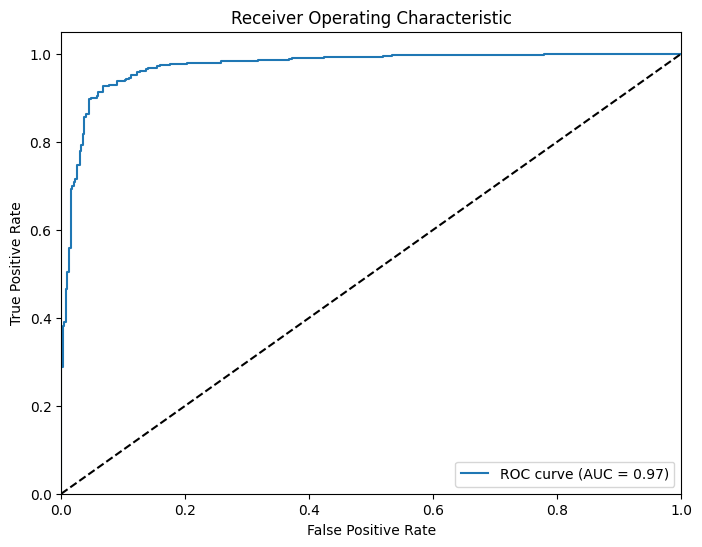

In [81]:
from sklearn.metrics import roc_curve, auc

# Assuming you have the predicted probabilities and true labels
y_pred_proba = voting_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## 3.6 Deep Learning Network (Pytorch)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random

# Set seeds
def set_seeds(seed):
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seeds(seed=42)

# Only use deterministic algorithms - Will raise error if not
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.benchmark = False

In [7]:
df = pd.read_csv(csv_path)

In [8]:
df['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

In [9]:
def preprocessing(csv_path):
    features = pd.read_csv(csv_path)
    features.drop(features.tail(1).index,inplace=True)
    features.drop(columns=['A_id'], inplace=True)
    labels = features.iloc[:, -1]
    features.drop('Quality', axis=1, inplace=True)
    features['Acidity'] = features['Acidity'].astype(float)
    return features, labels

In [10]:
from sklearn.model_selection import train_test_split
features, labels = preprocessing('/kaggle/input/apple-quality/apple_quality.csv')

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(3200, 7) (400, 7) (3200,) (400,)
(400, 7) (400, 7) (400,) (400,)


### Create Custom Tensor Dataset

In [11]:
# Create Custom Tensor Dataset
class AppleDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()

        # Encode the labels
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)

        # Convert the encoded labels to a tensor
        self.labels = torch.tensor(encoded_labels, requires_grad=True, dtype=torch.float32)
        
        self.features = torch.tensor(features.to_numpy(), requires_grad=True, dtype=torch.float32)
        
        self.classes_ = features.columns
        
    # The required methods for custom dataset class
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        return features, label
    
apple_train = AppleDataset(X_train, y_train)
apple_val = AppleDataset(X_val, y_val)
apple_test = AppleDataset(X_test, y_test)

In [12]:
features, label = apple_train[0]
print(f'Features: {features}')
print(f'Labels: {label}')

Features: tensor([ 1.4825, -2.5812, -0.3069,  1.5279,  1.0564,  2.5608, -1.2293],
       grad_fn=<SelectBackward0>)
Labels: 1.0


## 3.6.1 DataLoader Train Data

In [13]:
torch.initial_seed()

42

## Reproducible Results for DataLoader

In [14]:
# 1. Worker_init_fn is set to our custom set seeds function
# 2. Initialize torch generator and set manual seed
g = torch.Generator()
g.manual_seed(42)

# 3. Shuffle needs to be false (even for train data) to be deterministic 
# Batch is randomly chosen even with worker init function
apple_train_dataloader = DataLoader(
    apple_train,
    batch_size = 32,
    shuffle=False,    
    worker_init_fn=set_seeds,
    generator=g
)
apple_val_dataloader = DataLoader(
    apple_val,
    batch_size=32,
    shuffle=False,
    worker_init_fn=set_seeds,
    generator=g
)
apple_test_dataloader = DataLoader(
    apple_test,
    batch_size=32,
    shuffle=False,
    worker_init_fn=set_seeds,
    generator=g
)

In [15]:
features, labels = next(iter(apple_train_dataloader))
print(f'Features: {features}')
print(f'Labels: {label}')

Features: tensor([[ 1.4825, -2.5812, -0.3069,  1.5279,  1.0564,  2.5608, -1.2293],
        [-0.1661,  0.3856, -1.1029,  0.4738,  0.3255,  0.9832, -2.1719],
        [-2.5089, -2.8434, -0.8484, -0.4834, -0.0953,  5.1110, -1.8053],
        [-1.3805, -0.5214,  3.3357,  0.1440,  2.5138, -0.4667, -0.0305],
        [-2.0736, -1.2128, -0.8184,  3.8088,  1.0139,  0.7487,  0.0261],
        [-1.3741, -0.8000, -0.1954, -0.5217,  4.0766, -1.9733,  4.3481],
        [-1.2946,  2.8312, -2.7419,  0.9157,  0.8033,  0.0464, -4.4883],
        [-1.9753,  0.1489, -2.0653,  0.9718,  1.0100, -1.9965, -1.3108],
        [-1.7967,  0.3704, -1.0569,  1.8060,  2.4348, -0.3600, -2.9201],
        [ 1.6687,  2.7040,  0.3525,  0.1058,  2.0746, -1.6856,  3.5990],
        [ 2.7287, -2.7389, -4.5692,  3.4290,  2.3881,  0.5349,  0.4458],
        [-0.7827, -2.6366, -2.1953,  0.3983, -1.5029,  1.0904, -4.5755],
        [-1.4844, -1.1146, -4.6922, -1.3674,  0.1112,  6.0662, -1.9557],
        [-1.3768,  1.0880,  0.8262, -0.22

## 3.6.2 Building the Forward Pass Neural Network

In [16]:
class DeepNeuralNet(nn.Module):
    def __init__(self):
        super(DeepNeuralNet, self).__init__()
        # Defining the Layers
        self.fc1 = nn.Linear(7, 14)
        self.bn1 = nn.BatchNorm1d(14)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(14, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(7, 1)

        # Apply He initialization to create uniform weights for the model
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='sigmoid')

    def forward(self, x):
        x = nn.functional.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = nn.functional.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

### Early Stopping

In [17]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        # Initial val_loss
        if self.best_loss is None:
            self.best_loss = val_loss
            
        # Checking the state where best_loss - val_loss is greater than min_data
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            
        # Otherwise iterate counter and check patience
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

## 3.6.3 Training Loop w/ loss function and optimizer

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
from tqdm import tqdm

# Define the model
net = DeepNeuralNet()
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

# Define Number of Epochs
num_epochs = 150

# Early Stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Array to hold average losses per epoch
train_losses, val_losses = [], []

def create_model(model, train, val, loss, optimizer, num_epochs, early_stop=False, verbose=False):
    model = model.to(device)
    criterion = loss
    optimizer = optimizer
    
    # Reset Seeds for Training Loop
    set_seeds(seed=42)

    for epoch in tqdm(range(num_epochs)):
        train_running_loss = 0.0
        # Iterate over training batches
        for features, labels in train:
            features, labels = features.to(device), labels.to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Sum of Loss
            train_running_loss += loss.item()
            
        # Calculate the average loss for the epoch
        train_loss = train_running_loss / len(train)
        
        # Create Evaluation Loop
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for features, labels in val:
                features, labels = features.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                # Sum of Loss
                val_running_loss += loss.item()

        # Calculate the average loss for the epoch
        val_loss = val_running_loss / len(val)
        
        # Check val_loss for early stopping
        if early_stop:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print('Early Stopping')
                break
        
        # Append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        
        if verbose:
            print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    print(f'Best Train Loss: {min(train_losses)}, Best Validation Loss: {min(val_losses)}')
        
        
create_model(net, apple_train_dataloader, apple_val_dataloader, \
             criterion, optimizer, num_epochs, early_stop=True, verbose=False)

 91%|█████████ | 136/150 [01:06<00:06,  2.05it/s]

Early Stopping
Best Train Loss: 0.1867436031997204, Best Validation Loss: 0.23241990288862815


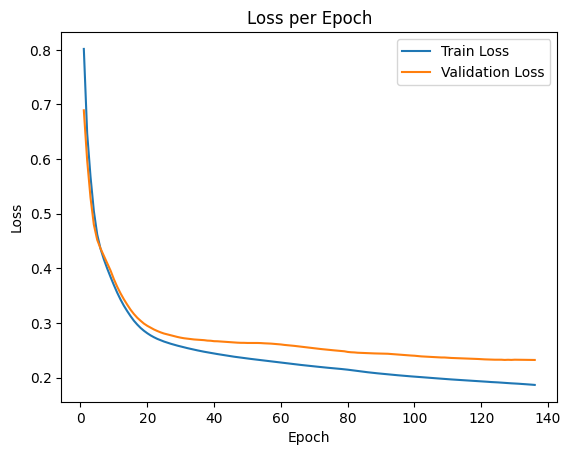

In [20]:
epoch_numbers = range(1, len(train_losses) + 1)

plt.plot(epoch_numbers, train_losses)
plt.plot(epoch_numbers, val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()


## 3.6.4 Deep Neural Network Prediction and Metrics

In [21]:
from torchmetrics import Accuracy

acc = Accuracy(task='binary').to(device)

net.eval()
with torch.no_grad():
    for features, labels in apple_test_dataloader:
        features, labels = features.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels)
        
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9125000238418579


## 3.6.5 DNN Hyperparameter Tuning using Optuna

In [22]:
import optuna
from optuna.trial import TrialState
import torch.nn as nn

def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []

    # Static In-Feature
    in_features = len(apple_train.classes_)
    for i in range(n_layers):
        # Choosing number of Out-Features (Integer)
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)

        # Define and initialize linear layer
        linear = nn.Linear(in_features, out_features)
        nn.init.kaiming_normal_(linear.weight, nonlinearity='leaky_relu')
        layers.append(linear)
        
        # Add Batch Normalization
        layers.append(nn.BatchNorm1d(out_features))  # Use out_features for batch normalization
        
        # Use LeakyReLU for activation to inhibit dead neurons and optimize slope for leaky relu
        negative_slope = trial.suggest_float("leaky_relu_slope_l{}".format(i), 1e-2, 0.3) 
        layers.append(nn.LeakyReLU(negative_slope))
        
        # Use dropout to withstand overfitting
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6)
        layers.append(nn.Dropout(p))

        in_features = out_features

    # Output layer
    layers.append(nn.Linear(in_features, 1))
    # Initialize the final layer
    nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='linear')

    return nn.Sequential(*layers)

In [23]:
def objective(trial):
    # Generate the model
    model = define_model(trial).to(device)
    
    # Loss Function - BCE with Logits
    criterion = nn.BCEWithLogitsLoss()
    
    # Metrics - Accuracy
    acc = Accuracy(task='binary').to(device)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    num_epochs = trial.suggest_int("num_epochs", 10, 200)

    # Training of the model
    for epoch in range(num_epochs):
        model.train()
        for features, labels in apple_train_dataloader:

            features, labels = features.view(features.size(0), -1).to(device), labels.to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model
        model.eval()
        correct = 0
        with torch.no_grad():
            for features, labels in apple_val_dataloader:

                features, labels = features.view(features.size(0), -1).to(device), labels.to(device)
                labels = labels.view(-1, 1)
                output = model(features)
                # Get predictions
                pred = (output >= 0.5).float()
                acc(pred, labels)

        accuracy = acc.compute()

        trial.report(accuracy, epoch)
        

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

## 3.6.6 Running Optuna Study

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-04 23:01:26,499] A new study created in memory with name: no-name-ef25b907-bdb6-4cf0-816c-a78c13ab9b90
[I 2024-04-04 23:02:26,640] Trial 0 finished with value: 0.745053768157959 and parameters: {'n_layers': 4, 'n_units_l0': 82, 'leaky_relu_slope_l0': 0.21326230447438757, 'dropout_l0': 0.37783015632225647, 'n_units_l1': 58, 'leaky_relu_slope_l1': 0.21432485130002285, 'dropout_l1': 0.3797913090703232, 'n_units_l2': 29, 'leaky_relu_slope_l2': 0.01707102941231502, 'dropout_l2': 0.5902126590231894, 'n_units_l3': 41, 'leaky_relu_slope_l3': 0.09820096220501365, 'dropout_l3': 0.3074412965561901, 'optimizer': 'Adam', 'lr': 0.00011144439012405917, 'num_epochs': 93}. Best is trial 0 with value: 0.745053768157959.
[I 2024-04-04 23:03:01,919] Trial 1 finished with value: 0.5732758641242981 and parameters: {'n_layers': 4, 'n_units_l0': 69, 'leaky_relu_slope_l0': 0.20036026954654573, 'dropout_l0': 0.32913921362878223, 'n_units_l1': 73, 'leaky_relu_slope_l1': 0.18329230323244375, 'dropout_l

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  54
  Number of complete trials:  46
Best trial:
  Value:  0.9430803656578064
  Params: 
    n_layers: 2
    n_units_l0: 113
    leaky_relu_slope_l0: 0.08720168555865028
    dropout_l0: 0.25216757518706734
    n_units_l1: 121
    leaky_relu_slope_l1: 0.06613371292455421
    dropout_l1: 0.41251832465407956
    optimizer: Adam
    lr: 0.005694031844823748
    num_epochs: 112


n_layers: 2
n_units_l0: 113
leaky_relu_slope_l0: 0.08720168555865028
dropout_l0: 0.25216757518706734
n_units_l1: 121
leaky_relu_slope_l1: 0.06613371292455421
dropout_l1: 0.41251832465407956
optimizer: Adam
lr: 0.005694031844823748
num_epochs: 112

## 3.6.7 Visual Accuracy - Optuna

In [25]:
plt.figure(figsize=(10, 6))
optuna.visualization.plot_optimization_history(study)

<Figure size 1000x600 with 0 Axes>

In [ ]:
n_layers: 2
n_units_l0: 113
leaky_relu_slope_l0: 0.08720168555865028
dropout_l0: 0.25216757518706734
n_units_l1: 121
leaky_relu_slope_l1: 0.06613371292455421
dropout_l1: 0.41251832465407956
optimizer: Adam
lr: 0.005694031844823748
num_epochs: 112

In [ ]:
def tuned_dnn_model():
    layers = []

    # Static In-Feature
    in_features = len(apple_train.classes_)
    for i in range(params['n_layers']):
        # Choosing number of Out-Features (Integer)
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)

        # Define and initialize linear layer
        linear = nn.Linear(in_features, out_features)
        nn.init.kaiming_normal_(linear.weight, nonlinearity='leaky_relu')
        layers.append(linear)
        
        # Add Batch Normalization
        layers.append(nn.BatchNorm1d(out_features))  # Use out_features for batch normalization
        
        # Use LeakyReLU for activation to inhibit dead neurons and optimize slope for leaky relu
        negative_slope = trial.suggest_float("leaky_relu_slope_l{}".format(i), 1e-2, 0.3) 
        layers.append(nn.LeakyReLU(negative_slope))
        
        # Use dropout to withstand overfitting
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6)
        layers.append(nn.Dropout(p))

        in_features = out_features

    # Output layer
    layers.append(nn.Linear(in_features, 1))
    # Initialize the final layer
    nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='linear')

    return nn.Sequential(*layers)

In [45]:
params = {'n_layers': 2,
'n_units_l0': 113,
'leaky_relu_slope_l0': 0.08720168555865028,
'dropout_l0': 0.25216757518706734,
'n_units_l1': 121,
'leaky_relu_slope_l1': 0.06613371292455421,
'dropout_l1': 0.41251832465407956,
'optimizer': 'Adam',
'lr': 0.005694031844823748,
'num_epochs': 112}

In [47]:
class DeepNeuralNet(nn.Module):
    def __init__(self):
        super(DeepNeuralNet, self).__init__()
        # Defining the Layers
        self.fc1 = nn.Linear(len(apple_train.classes_), params['n_units_l0'])
        self.bn1 = nn.BatchNorm1d(params['n_units_l0'])
        self.dropout1 = nn.Dropout(p=params['dropout_l0'])
        self.fc2 = nn.Linear(params['n_units_l0'], params['n_units_l1'])
        self.bn2 = nn.BatchNorm1d(params['n_units_l1'])
        self.dropout2 = nn.Dropout(p=params['dropout_l1'])
        self.fc3 = nn.Linear(params['n_units_l1'], 1)

        # Apply He initialization to create uniform weights for the model
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='linear')

    def forward(self, x):
        x = nn.functional.leaky_relu(self.bn1(self.fc1(x)), 0.08720168555865028)
        x = self.dropout1(x)
        x = nn.functional.leaky_relu(self.bn2(self.fc2(x)), 0.06613371292455421)
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

In [49]:
from tqdm import tqdm

# Define the model
net = DeepNeuralNet()
# Define the loss function
criterion = nn.BCEWithLogitsLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'])

# Define Number of Epochs
num_epochs = params['num_epochs']

# # Early Stopping
# early_stopping = EarlyStopping(patience=10, min_delta=0.001)

# Array to hold average losses per epoch
train_losses, val_losses = [], []

def create_model(model, train, val, loss, optimizer, num_epochs, early_stop=False, verbose=False):
    model = model.to(device)
    criterion = loss
    optimizer = optimizer
    
    # Reset Seeds for Training Loop
    set_seeds(seed=42)

    for epoch in tqdm(range(num_epochs)):
        train_running_loss = 0.0
        # Iterate over training batches
        for features, labels in train:
            features, labels = features.to(device), labels.to(device)
            labels = labels.view(-1, 1)
            optimizer.zero_grad()
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Sum of Loss
            train_running_loss += loss.item()
            
        # Calculate the average loss for the epoch
        train_loss = train_running_loss / len(train)
        
        # Create Evaluation Loop
        model.eval()
        val_running_loss = 0.0
        
        with torch.no_grad():
            for features, labels in val:
                features, labels = features.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                # Sum of Loss
                val_running_loss += loss.item()

        # Calculate the average loss for the epoch
        val_loss = val_running_loss / len(val)
        
        # Check val_loss for early stopping
        if early_stop:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print('Early Stopping')
                break
        
        # Append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        
        if verbose:
            print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    print(f'Best Train Loss: {min(train_losses)}, Best Validation Loss: {min(val_losses)}')
        
        
create_model(net, apple_train_dataloader, apple_val_dataloader, \
             criterion, optimizer, num_epochs, early_stop=False, verbose=False)

100%|██████████| 112/112 [00:52<00:00,  2.14it/s]

Best Train Loss: 0.008243762789220455, Best Validation Loss: 0.20395142251912218


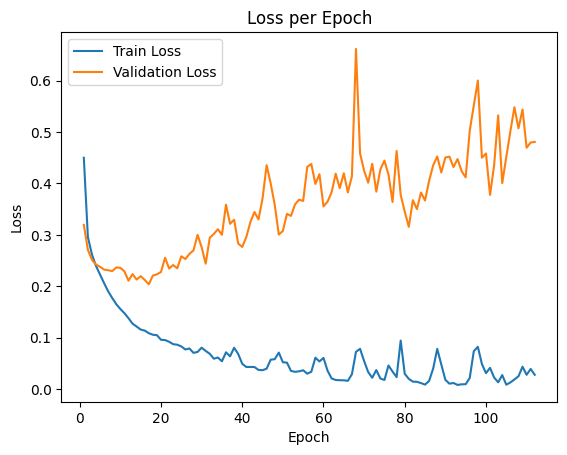

In [50]:
epoch_numbers = range(1, len(train_losses) + 1)

plt.plot(epoch_numbers, train_losses)
plt.plot(epoch_numbers, val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()


In [52]:
from torchmetrics import Accuracy

acc = Accuracy(task='binary').to(device)

net.eval()
with torch.no_grad():
    for features, labels in apple_test_dataloader:
        features, labels = features.to(device), labels.to(device)
        labels = labels.view(-1, 1)
        outputs = net(features)
        preds = (outputs >= 0.5).float()
        acc(preds, labels)
        
test_accuracy = acc.compute()
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9275000095367432


# 4. Using joblib to dump classifiers

In [ ]:
# from joblib import dump, load

In [ ]:
# dump(voting_classifier, 'apple_quality_xgb.joblib')